### Text-to-Handwritten Image Generation via GANs

### User uploads their handwritten picture and a text paragraph , and our model converts it to user handwritten image

In [ ]:
import os
from glob import glob
import random
import string

import numpy as np
from PIL import Image, UnidentifiedImageError

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from torchvision.utils import make_grid, save_image

import matplotlib.pyplot as plt

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)

DATA_ROOT = "/kaggle/input/iam-handwriting-word-database/iam_words"


# image size for words
IMG_H = 64
IMG_W = 256

BATCH_SIZE = 64
NUM_EPOCHS = 10

Z_DIM = 64             # noise noise dim
STYLE_DIM = 64         # style embedding dim
TEXT_DIM = 64          # text embedding dim
LR = 2e-4

MAX_WORD_LEN = 20      # max chars per word

SAMPLE_DIR = "./samples_words"
os.makedirs(SAMPLE_DIR, exist_ok=True)

MODEL_DIR = "./saved_models"
os.makedirs(MODEL_DIR, exist_ok=True)


# TEXT / VOCAB UTILITIES
# simple character set: lowercase + digits + basic punctuation + space
CHARS = list(string.ascii_lowercase + string.digits + ".,-!'? ")  # add more if needed
PAD_TOKEN = "<pad>"
UNK_TOKEN = "<unk>"

itos = [PAD_TOKEN, UNK_TOKEN] + CHARS
stoi = {ch: i for i, ch in enumerate(itos)}

VOCAB_SIZE = len(itos)
PAD_IDX = stoi[PAD_TOKEN]
UNK_IDX = stoi[UNK_TOKEN]

def text_to_ids(text, max_len=MAX_WORD_LEN):
    text = text.lower()
    ids = []
    for ch in text:
        if ch in stoi:
            ids.append(stoi[ch])
        else:
            ids.append(UNK_IDX)
    if len(ids) < max_len:
        ids += [PAD_IDX] * (max_len - len(ids))
    else:
        ids = ids[:max_len]
    return ids

def denorm(x):
    # from [-1,1] back to [0,1]
    return x * 0.5 + 0.5


Device: cuda


In [ ]:
class IAMWordDataset(Dataset):
    """
    Correct IAM word dataset loader using iam_words/words.txt and iam_words/words/*
    """

    def __init__(self, root_dir, transform=None, split="train", split_ratio=0.9):
        self.root_dir = root_dir
        self.transform = transform

        labels_path = os.path.join(root_dir, "words.txt")
        images_root = os.path.join(root_dir, "words")

        all_samples = []

        with open(labels_path, "r") as f:
            for line in f:
                line = line.strip()
                if not line or line.startswith("#"):
                    continue

                parts = line.split()
                img_id = parts[0]      # e.g., g05-094-07-01
                word = parts[-1]       # last token is the actual word

                # IAM path pattern: words/g05/g05-094/g05-094-07-01.png
                prefix = img_id[:3]    # g05
                page = img_id[:7]      # g05-094
                img_name = img_id + ".png"

                img_path = os.path.join(images_root, prefix, page, img_name)

                all_samples.append((img_path, word))

        print("Total entries in words.txt:", len(all_samples))

        # filter missing/corrupted images
        valid_samples = []
        for img_path, word in all_samples:
            if not os.path.exists(img_path):
                continue
            try:
                with Image.open(img_path) as im:
                    im.verify()
                valid_samples.append((img_path, word))
            except (UnidentifiedImageError, OSError):
                print("Skipping corrupted image:", img_path)

        self.samples_all = valid_samples
        print("Valid image-count after filtering:", len(self.samples_all))

        # train/val split
        random.seed(42)
        random.shuffle(self.samples_all)
        split_idx = int(len(self.samples_all) * split_ratio)

        if split == "train":
            self.samples = self.samples_all[:split_idx]
        else:
            self.samples = self.samples_all[split_idx:]

        print(f"{split} samples:", len(self.samples))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, word = self.samples[idx]
        try:
            img = Image.open(img_path).convert("L")
        except (UnidentifiedImageError, OSError):
            # very rare fallback: blank image
            img = Image.new("L", (IMG_W, IMG_H), color=255)

        if self.transform:
            img = self.transform(img)

        text_ids = torch.tensor(text_to_ids(word), dtype=torch.long)
        return img, text_ids, word


# Transform: resize -> tensor -> normalize to [-1, 1]
transform = T.Compose([
    T.Resize((IMG_H, IMG_W)),
    T.ToTensor(),                       # [0,1]
    T.Normalize(mean=[0.5], std=[0.5])  # -> [-1,1]
])

train_dataset = IAMWordDataset(DATA_ROOT, transform=transform, split="train")
val_dataset   = IAMWordDataset(DATA_ROOT, transform=transform, split="val")

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE,
                          shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE,
                          shuffle=False, num_workers=2, pin_memory=True)

print("Train size:", len(train_dataset), "Val size:", len(val_dataset))

Total entries in words.txt: 44565
Skipping corrupted image: /kaggle/input/iam-handwriting-word-database/iam_words/words/a01/a01-117/a01-117-05-02.png
Valid image-count after filtering: 37106
train samples: 33395
Total entries in words.txt: 44565
Skipping corrupted image: /kaggle/input/iam-handwriting-word-database/iam_words/words/a01/a01-117/a01-117-05-02.png
Valid image-count after filtering: 37106
val samples: 3711
Train size: 33395 Val size: 3711


In [ ]:
class TextEncoder(nn.Module):
    """
    Char-level encoder -> text embedding.
    """
    def __init__(self, vocab_size, emb_dim=64, hidden_dim=TEXT_DIM, pad_idx=PAD_IDX):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim, padding_idx=pad_idx)
        self.rnn = nn.GRU(emb_dim, hidden_dim, batch_first=True)

    def forward(self, text_ids):
        x = self.emb(text_ids)      # [B,T,emb_dim]
        _, h = self.rnn(x)         # h: [1,B,hidden_dim]
        return h.squeeze(0)        # [B,hidden_dim]


class StyleEncoder(nn.Module):
    """
    CNN that encodes a word image into a style vector.
    """
    def __init__(self, style_dim=STYLE_DIM):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, 4, 2, 1), nn.ReLU(True),              # 64x256 -> 32x128
            nn.Conv2d(32, 64, 4, 2, 1), nn.BatchNorm2d(64), nn.ReLU(True),  # 16x64
            nn.Conv2d(64, 128, 4, 2, 1), nn.BatchNorm2d(128), nn.ReLU(True), # 8x32
            nn.Conv2d(128, 256, 4, 2, 1), nn.BatchNorm2d(256), nn.ReLU(True),# 4x16
        )
        self.fc = nn.Linear(256 * 4 * 16, style_dim)

    def forward(self, imgs):
        feat = self.conv(imgs)
        feat = feat.view(feat.size(0), -1)
        style = self.fc(feat)
        return style


def weights_init(m):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d, nn.Linear)):
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        if getattr(m, "bias", None) is not None:
            nn.init.constant_(m.bias.data, 0)


class Generator(nn.Module):
    """
    Word generator conditioned on: noise + style + text.
    """
    def __init__(self, z_dim, style_dim, text_dim, img_channels=1, feature_g=64):
        super().__init__()
        in_dim = z_dim + style_dim + text_dim
        self.fc = nn.Linear(in_dim, feature_g * 8 * 4 * 16)  # 4x16

        self.net = nn.Sequential(
            nn.ConvTranspose2d(feature_g * 8, feature_g * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_g * 4),
            nn.ReLU(True),

            nn.ConvTranspose2d(feature_g * 4, feature_g * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_g * 2),
            nn.ReLU(True),

            nn.ConvTranspose2d(feature_g * 2, feature_g, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_g),
            nn.ReLU(True),

            nn.ConvTranspose2d(feature_g, img_channels, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, z, style_emb, text_emb):
        cond = torch.cat([z, style_emb, text_emb], dim=1)  # [B, z+style+text]
        x = self.fc(cond)
        x = x.view(x.size(0), -1, 4, 16)
        img = self.net(x)   # [B,1,64,256]
        return img


class Discriminator(nn.Module):
    """
    Discriminator conditioned on style (projection).
    """
    def __init__(self, style_dim, img_channels=1, feature_d=64):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(img_channels, feature_d, 4, 2, 1),      # 64x256 -> 32x128
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(feature_d, feature_d * 2, 4, 2, 1),
            nn.BatchNorm2d(feature_d * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(feature_d * 2, feature_d * 4, 4, 2, 1),
            nn.BatchNorm2d(feature_d * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(feature_d * 4, feature_d * 8, 4, 2, 1),
            nn.BatchNorm2d(feature_d * 8),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.fc_adv = nn.Linear(feature_d * 8 * 4 * 16, 1)
        self.fc_style = nn.Linear(feature_d * 8 * 4 * 16, style_dim)

    def forward(self, img, style_emb):
        feat = self.conv(img)
        feat = feat.view(feat.size(0), -1)
        adv_logit = self.fc_adv(feat).squeeze(1)
        style_feat = self.fc_style(feat)
        proj = (style_feat * style_emb).sum(dim=1)
        return adv_logit + proj


text_encoder = TextEncoder(VOCAB_SIZE).to(DEVICE)
style_encoder = StyleEncoder().to(DEVICE)
G = Generator(Z_DIM, STYLE_DIM, TEXT_DIM).to(DEVICE)
D = Discriminator(STYLE_DIM).to(DEVICE)

text_encoder.apply(weights_init)
style_encoder.apply(weights_init)
G.apply(weights_init)
D.apply(weights_init)

Discriminator(
  (conv): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (fc_adv): Linear(in_features=32768, out_features=1, bias=True)
  (fc_style): Linear(in_features=32768, out_features=64, bias=True)
)

In [30]:
NUM_EPOCHS=8

In [ ]:
criterion_gan = nn.BCEWithLogitsLoss()
criterion_l1 = nn.L1Loss()

optimizer_D = optim.Adam(list(D.parameters()) + list(style_encoder.parameters()),
                         lr=LR, betas=(0.5, 0.999))
optimizer_G = optim.Adam(list(G.parameters()) + list(style_encoder.parameters()) +
                         list(text_encoder.parameters()),
                         lr=LR, betas=(0.5, 0.999))

def real_fake_labels(bs, device):
    real = torch.ones(bs, device=device)
    fake = torch.zeros(bs, device=device)
    return real, fake

fixed_noise = torch.randn(16, Z_DIM, device=DEVICE)

for epoch in range(1, NUM_EPOCHS + 1):
    G.train()
    D.train()
    text_encoder.train()
    style_encoder.train()

    d_loss_epoch = 0.0
    g_loss_epoch = 0.0
    n_samples = 0

    for real_imgs, text_ids, words in train_loader:
        real_imgs = real_imgs.to(DEVICE)
        text_ids = text_ids.to(DEVICE)
        bs = real_imgs.size(0)
        n_samples += bs

        real_labels, fake_labels = real_fake_labels(bs, DEVICE)

        # style + text from real images
        style_emb = style_encoder(real_imgs)
        text_emb = text_encoder(text_ids)

        # ----- Train D -----
        optimizer_D.zero_grad()

        logits_real = D(real_imgs, style_emb.detach())
        loss_real = criterion_gan(logits_real, real_labels)

        z = torch.randn(bs, Z_DIM, device=DEVICE)
        fake_imgs = G(z, style_emb.detach(), text_emb.detach())
        logits_fake = D(fake_imgs.detach(), style_emb.detach())
        loss_fake = criterion_gan(logits_fake, fake_labels)

        loss_D = loss_real + loss_fake
        loss_D.backward()
        optimizer_D.step()

        # ----- Train G -----
        optimizer_G.zero_grad()

        z = torch.randn(bs, Z_DIM, device=DEVICE)
        fake_imgs = G(z, style_emb, text_emb)
        logits_fake_for_G = D(fake_imgs, style_emb)

        loss_G_gan = criterion_gan(logits_fake_for_G, real_labels)
        loss_G_l1 = criterion_l1(fake_imgs, real_imgs)
        loss_G = loss_G_gan + 10.0 * loss_G_l1

        loss_G.backward()
        optimizer_G.step()

        d_loss_epoch += loss_D.item() * bs
        g_loss_epoch += loss_G.item() * bs

    d_loss_epoch /= n_samples
    g_loss_epoch /= n_samples

    print(f"Epoch [{epoch}/{NUM_EPOCHS}]  D_loss: {d_loss_epoch:.4f}  G_loss: {g_loss_epoch:.4f}")

    # Save sample grid every few epochs
    if epoch == 1 or epoch % 5 == 0:
        G.eval()
        text_encoder.eval()
        style_encoder.eval()
        with torch.no_grad():
            try:
                real_imgs_val, text_ids_val, words_val = next(iter(val_loader))
            except StopIteration:
                real_imgs_val, text_ids_val, words_val = next(iter(train_loader))

            real_imgs_val = real_imgs_val.to(DEVICE)[:16]
            text_ids_val = text_ids_val.to(DEVICE)[:16]

            style_emb_val = style_encoder(real_imgs_val)
            text_emb_val = text_encoder(text_ids_val)
            z = torch.randn(16, Z_DIM, device=DEVICE)
            fake_samples = G(z, style_emb_val, text_emb_val)
            fake_samples = denorm(fake_samples)
            grid = make_grid(fake_samples.cpu(), nrow=8)
            save_path = os.path.join(SAMPLE_DIR, f"epoch_{epoch:03d}.png")
            save_image(grid, save_path)
            print("Saved sample grid at:", save_path)

# Save models
torch.save(G.state_dict(), os.path.join(MODEL_DIR, "generator.pth"))
torch.save(D.state_dict(), os.path.join(MODEL_DIR, "discriminator.pth"))
torch.save(style_encoder.state_dict(), os.path.join(MODEL_DIR, "style_encoder.pth"))
torch.save(text_encoder.state_dict(), os.path.join(MODEL_DIR, "text_encoder.pth"))
print("Models saved.")


Epoch [1/8]  D_loss: 0.4266  G_loss: 10.4818
Saved sample grid at: ./samples_words/epoch_001.png
Epoch [2/8]  D_loss: 0.6926  G_loss: 6.2592
Epoch [3/8]  D_loss: 0.7480  G_loss: 6.0082
Epoch [4/8]  D_loss: 0.6887  G_loss: 6.2932
Epoch [5/8]  D_loss: 0.5603  G_loss: 6.7252
Saved sample grid at: ./samples_words/epoch_005.png
Epoch [6/8]  D_loss: 0.5380  G_loss: 6.8893
Epoch [7/8]  D_loss: 0.4253  G_loss: 7.2530
Epoch [8/8]  D_loss: 0.4000  G_loss: 7.7265
Models saved.


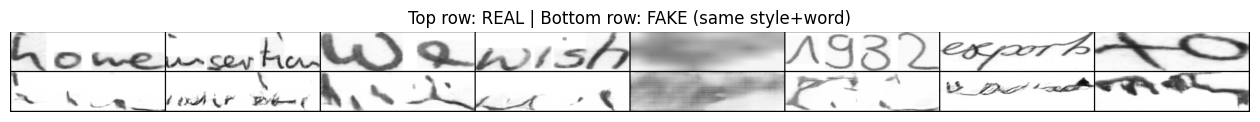

Words: ['home', 'insertion', 'We', 'wish', '.', '1932', 'exports', 'to']


In [ ]:
G.eval()
style_encoder.eval()
text_encoder.eval()

real_imgs, text_ids, words = next(iter(val_loader))
real_imgs = real_imgs.to(DEVICE)
text_ids = text_ids.to(DEVICE)
bs = real_imgs.size(0)

with torch.no_grad():
    style_emb = style_encoder(real_imgs)
    text_emb = text_encoder(text_ids)
    z = torch.randn(bs, Z_DIM, device=DEVICE)
    fake_imgs = G(z, style_emb, text_emb)

real_vis = denorm(real_imgs).cpu()
fake_vis = denorm(fake_imgs).cpu()

n_show = 8
pairs = torch.cat([real_vis[:n_show], fake_vis[:n_show]], dim=0)
grid = make_grid(pairs, nrow=n_show)

plt.figure(figsize=(16, 4))
plt.imshow(grid.permute(1, 2, 0).squeeze(), cmap="gray")
plt.axis("off")
plt.title("Top row: REAL | Bottom row: FAKE (same style+word)")
plt.show()

print("Words:", words[:n_show])

### As the model is just trained for 8 epoch that's why the outputs are hazy , if we increase the number of epoch then we can get good outputs

### Below is the Gradio App 

### User uploads their handwritten picture and a text paragraph , and our model converts it to user handwritten image

In [ ]:
import gradio as gr

# Reload models for safety
G_inf = Generator(Z_DIM, STYLE_DIM, TEXT_DIM).to(DEVICE)
style_encoder_inf = StyleEncoder().to(DEVICE)
text_encoder_inf = TextEncoder(VOCAB_SIZE).to(DEVICE)

G_inf.load_state_dict(torch.load(os.path.join(MODEL_DIR, "generator.pth"), map_location=DEVICE))
style_encoder_inf.load_state_dict(torch.load(os.path.join(MODEL_DIR, "style_encoder.pth"), map_location=DEVICE))
text_encoder_inf.load_state_dict(torch.load(os.path.join(MODEL_DIR, "text_encoder.pth"), map_location=DEVICE))

G_inf.eval()
style_encoder_inf.eval()
text_encoder_inf.eval()

style_transform = transform  # reuse training transform


def generate_word_image(word, style_emb):
    ids = torch.tensor(text_to_ids(word), dtype=torch.long).unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        text_emb = text_encoder_inf(ids)
        z = torch.randn(1, Z_DIM, device=DEVICE)
        fake_img = G_inf(z, style_emb, text_emb)
        fake_img = denorm(fake_img).cpu()
    arr = fake_img.squeeze(0).squeeze(0).numpy() * 255.0
    arr = arr.clip(0, 255).astype(np.uint8)
    return Image.fromarray(arr)


def encode_style_from_uploaded_files(filepaths):
    if not filepaths or len(filepaths) == 0:
        raise gr.Error("Please upload at least one handwriting sample image.")

    pil_images = []
    for p in filepaths:
        img = Image.open(p).convert("L")
        img = style_transform(img)
        pil_images.append(img)

    imgs = torch.stack(pil_images, dim=0).to(DEVICE)
    with torch.no_grad():
        style_emb = style_encoder_inf(imgs).mean(dim=0, keepdim=True)
    return style_emb


def generate_paragraph_from_gradio(filepaths, paragraph):
    style_emb = encode_style_from_uploaded_files(filepaths)

    words = paragraph.strip().split()
    if len(words) == 0:
        raise gr.Error("Please enter some text.")

    word_imgs = [generate_word_image(w, style_emb) for w in words]

    line_max_width = 1500
    line_spacing = 10
    lines = []
    current_line = []
    current_width = 0

    for img in word_imgs:
        w, h = img.size
        if current_width + w > line_max_width and current_line:
            lines.append(current_line)
            current_line = []
            current_width = 0
        current_line.append(img)
        current_width += w + 10
    if current_line:
        lines.append(current_line)

    if not lines:
        raise gr.Error("No words to render.")

    line_heights = [max(im.size[1] for im in line) for line in lines]
    total_height = sum(line_heights) + line_spacing * (len(lines) - 1)
    total_width = line_max_width

    para_img = Image.new("L", (total_width, total_height), color=255)
    y = 0
    for line, h in zip(lines, line_heights):
        x = 0
        for im in line:
            w, hh = im.size
            para_img.paste(im, (x, y + (h - hh) // 2))
            x += w + 10
        y += h + line_spacing

    return para_img


with gr.Blocks() as demo:
    gr.Markdown("## ✍️ Handwriting Style Transfer\nUpload handwriting samples + paragraph, get the paragraph in that style.")

    with gr.Row():
        style_input = gr.Files(
            label="Upload 2–5 handwriting sample images",
            file_types=["image"],
            file_count="multiple",
            type="filepath"
        )
        text_input = gr.Textbox(
            label="Paragraph text",
            lines=6,
            placeholder="Type your paragraph here..."
        )

    output_image = gr.Image(
        label="Generated handwritten paragraph",
        type="pil"
    )

    generate_button = gr.Button("Generate")

    generate_button.click(
        fn=generate_paragraph_from_gradio,
        inputs=[style_input, text_input],
        outputs=output_image
    )

demo.launch()

* Running on local URL:  http://127.0.0.1:7862
It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

* Running on public URL: https://bfb96da79c5730e5fa.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
